#Reading CIFAR-10 and creating dataloaders



1) The CIFAR-10 dataset has been viewed/downloaded from the University of Toronto website.

2) Data augmenting steps have been applied to the training dataset to increase the randomness in the training set to increase generalisability of the model and to avoid overfitting.

3) Both training and testing data have been normalised, transformed into tensors and the appropriate trainloader/testloader dataloaders have been created.

4) The class labels have been defined.

5) The input tensor shapes have been printed to check shape.

In [ ]:
# importing relavent libraries

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

# defining the transformation functions for loading the training and testing data
# data augmentation has been used on the training data to increase randomness in the training set to increase generalisability/ avoid overfitting

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.RandomCrop(32, padding=4), # data augmentation
    transforms.RandomRotation(degrees=15), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # normalising training data
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # normalising testing data
])


# loading the CIFAR-10 traininf and testing data

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# creating dataloaders

trainloader = torch.utils.data.DataLoader(trainset, batch_size=200,
                                          shuffle=True, num_workers=2) # training dataloader object
testloader = torch.utils.data.DataLoader(testset, batch_size=200,
                                         shuffle=False, num_workers=2) # testing dataloader object

# defining class labels

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# accessing labels from dataloaders

for images, labels in trainloader:
    print(images.shape)  # tensor shape of image batchs
    print(labels.shape)  # tensor shape of label batchs
    break


Files already downloaded and verified
Files already downloaded and verified
torch.Size([200, 3, 32, 32])
torch.Size([200])


# Creating the model

In [ ]:
class MyModel(nn.Module):
    def __init__(self, num_blocks, hidden_layers, hidden_units):
        super(MyModel, self).__init__()

        # The backbone

        self.blocks = nn.ModuleList()
        out_channels = [64,128,256,512] # parameters to be tuned
        kernel_sizes = [3, 1] # parameters to be tuned
        in_channels = 3
        for i in range(num_blocks): # creating blocks
            block_layers = nn.ModuleList()
            for kernel_size in kernel_sizes:
                for out_channel in out_channels:
                    block_layers.append(nn.Conv2d(in_channels, out_channel, kernel_size=kernel_size, padding='same', bias=False)) # Convloutional layer
                    block_layers.append(nn.BatchNorm2d(out_channel)) # batch normalisation
                    block_layers.append(nn.ReLU(inplace=False)) # Relu activation function
                    in_channels = out_channel
            block_layers.append(nn.AdaptiveAvgPool2d(1)) #SpatialAveragePooling
            block_layers.append(nn.Flatten())
            block_layers.append(nn.Linear(out_channels[-1], hidden_units)) # MLP layer
            block_layers.append(nn.BatchNorm1d(hidden_units)) # batch normalisation
            block_layers.append(nn.ReLU(inplace=False)) # Relu activation function
            in_channels = hidden_units
            self.blocks.append(nn.Sequential(*block_layers))

        # The classifier

        self.classifier = nn.Sequential()

        if hidden_layers > 0:
            self.classifier.add_module('hidden_layer_0', nn.Linear(hidden_units, hidden_units)) # MLP classifier layer
            self.classifier.add_module('bn_hidden_layer_0', nn.BatchNorm1d(hidden_units)) # batch normalisation
            self.classifier.add_module('relu_0', nn.ReLU(inplace=False)) # Relu activation function
            for i in range(1, hidden_layers):
                self.classifier.add_module(f'hidden_layer_{i}', nn.Linear(hidden_units, hidden_units)) # MLP classifier layer
                self.classifier.add_module(f'bn_hidden_layer_{i}', nn.BatchNorm1d(hidden_units)) # batch normalisation
                self.classifier.add_module(f'relu_{i}', nn.ReLU(inplace=False)) # Relu activation function
            self.classifier.add_module('output_layer', nn.Linear(hidden_units, 10)) # output MLP layer
        else:
            self.classifier.add_module('output_layer', nn.Linear(out_channels[-1], 10)) # output MLP layer

    def forward(self, x):
        x = x.float()
        if x.dim() == 3:
          x = x.unsqueeze(0)
        batch_size = x.shape[0]
        x = x.view(batch_size, -1, *x.shape[2:])  # flattening dimensions except the batch dimension
        for i, block in enumerate(self.blocks):
            x = block(x)
            # reshaping the output of the block
            x = x.view(x.shape[0], -1, 1, 1)
        x = self.classifier(x.squeeze())
        return x


In [ ]:
# initialising the model
# model parameters[can be tuned]:

num_blocks = 2  # Number of blocks in the backbone
hidden_layers = 3  # Number of hidden layers in the MLP classifier
hidden_units = 256  # Number of hidden units in each hidden layer of the MLP classifier

# printing the models architecture

model = MyModel( num_blocks, hidden_layers, hidden_units)
print(model)

MyModel(
  (blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
      (12): Conv2d(512, 64, kernel_size=(1, 1), stride=(1, 1), padding=same, bias=False)
      (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

#Creating the loss and optimiser

I will be calculating loss using the Cross-Entropy Loss method. Stochastic gradient descent is used as the optimizer.

In [ ]:
# creating cross-entropy loss
loss = nn.CrossEntropyLoss()

# defining an optimizer
lr = 0.15 # Learning rate
wd = 0  # Weight decay (regularization)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)  # SGD optimizer with given learning rate and weight decay

# Training script

In [ ]:
# Importing library for plotting
import matplotlib.pyplot as plt

# using GPU for faster computations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# function for plotting loss, training & validation accuracies
def train_plt(model, trainloader, testloader, loss, optimizer, epochs):
    model.to(device)  # moving the model to the device
    model.train()  # setting the model to training mode
    train_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0
        for batch_idx, (X, y) in enumerate(trainloader):
            X, y = X.to(device), y.to(device)  # moving the data to the device
            optimizer.zero_grad()
            y_hat = model(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            epoch_loss += l.item()  # accumulating batch loss

            _, predicted = y_hat.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()

        epoch_loss /= len(trainloader)  # average loss for the epoch
        train_losses.append(epoch_loss)  # storing the epoch loss

        epoch_accuracy = 100. * correct / total
        train_accuracies.append(epoch_accuracy)  # storing the epoch accuracy

        # computing validation accuracy

        model.eval()  # setting the model to evaluation mode
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (X, y) in enumerate(testloader):
                X, y = X.to(device), y.to(device)  # moving the data to the device
                y_hat = model(X)  # forward pass to obtain model predictions
                _, predicted = y_hat.max(1)
                total += y.size(0)
                correct += predicted.eq(y).sum().item()

        valid_accuracy = 100. * correct / total
        valid_accuracies.append(valid_accuracy)  # storing the validation accuracy

        model.train()  # setting the model back to training mode

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%, '
              f'Validation Accuracy: {valid_accuracy:.2f}%')

    # plotting the evolution of loss, training accuracy, and validation accuracy

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Evolution of Loss')

    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Training Accuracy (%)')
    plt.title('Evolution of Training Accuracy')

    plt.subplot(1, 3, 3)
    plt.plot(valid_accuracies, color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy (%)')
    plt.title('Evolution of Validation Accuracy')

    plt.tight_layout()
    plt.show()


Using device: cuda


Epoch [1/300], Loss: 1.9172, Training Accuracy: 26.48%, Validation Accuracy: 29.92%
Epoch [2/300], Loss: 1.6703, Training Accuracy: 36.27%, Validation Accuracy: 39.16%
Epoch [3/300], Loss: 1.5134, Training Accuracy: 43.25%, Validation Accuracy: 39.38%
Epoch [4/300], Loss: 1.3833, Training Accuracy: 49.04%, Validation Accuracy: 46.25%
Epoch [5/300], Loss: 1.2667, Training Accuracy: 54.17%, Validation Accuracy: 48.81%
Epoch [6/300], Loss: 1.1790, Training Accuracy: 57.73%, Validation Accuracy: 47.25%
Epoch [7/300], Loss: 1.1020, Training Accuracy: 60.71%, Validation Accuracy: 58.06%
Epoch [8/300], Loss: 1.0345, Training Accuracy: 63.52%, Validation Accuracy: 59.51%
Epoch [9/300], Loss: 0.9919, Training Accuracy: 65.07%, Validation Accuracy: 65.66%
Epoch [10/300], Loss: 0.9343, Training Accuracy: 67.50%, Validation Accuracy: 65.21%
Epoch [11/300], Loss: 0.8967, Training Accuracy: 68.54%, Validation Accuracy: 67.09%
Epoch [12/300], Loss: 0.8603, Training Accuracy: 70.07%, Validation Accura

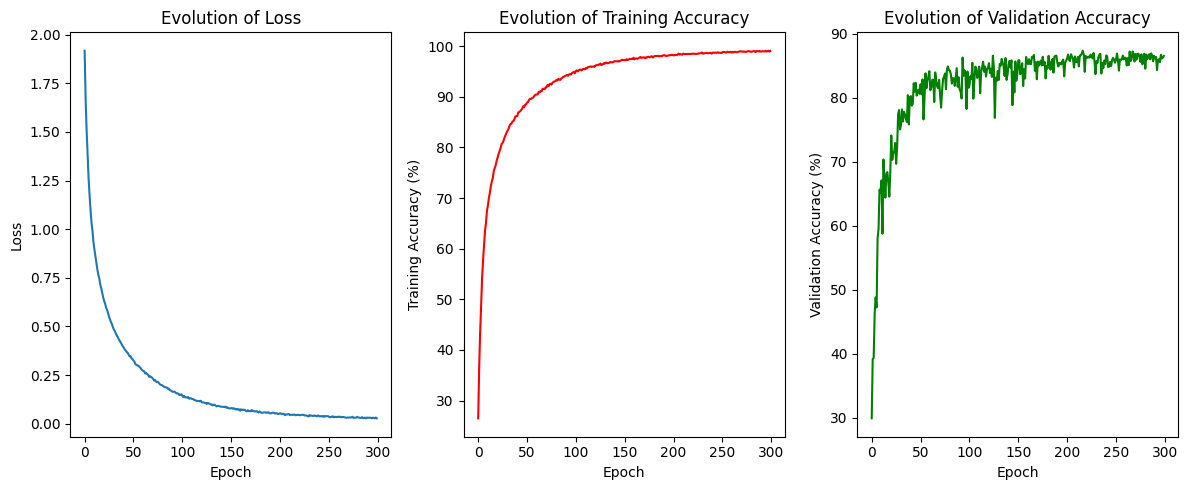

In [ ]:
train_plt(model, trainloader, testloader, loss, optimizer, 300)

# Final model accuracy on validation set

In [ ]:
# final model evaluation (Validation Accuracy)

model.eval()  # setting the model to evaluation mode

test_losses = 0.0
correct = 0
total = 0

with torch.no_grad():  # disabling gradient computation during evaluation
    for batch_idx, (testX, testY) in enumerate(testloader):
        testX = testX.to(device)
        testY = testY.to(device)
        outputs = model(testX)
        _, predicted = outputs.max(1)  # getting predicted labels
        total += testY.size(0)
        correct += predicted.eq(testY).sum().item()  # accumulating number of correct predictions

# computing accuracy
acc = 100.0 * correct / total

print('The final model Validation/Testing accuracy is:  %.3f' % acc)


The final model Validation/Testing accuracy is:  86.550
